## Find bagel shops in New York City

In [1]:
from pyplaces import foursquare_open_places as fsq
import folium

In [2]:
def plot_geodataframes(gdfs, zoom_start=11, popup_columns=None):
    if not isinstance(gdfs, list):
        gdfs = [gdfs]
    if popup_columns is None:
        popup_columns = [None] * len(gdfs)

    # Filter out empty GeoDataFrames
    gdfs_filtered = [(gdf, popup_columns[i]) for i, gdf in enumerate(gdfs) if not gdf.empty]

    if not gdfs_filtered:
        print("All GeoDataFrames are empty.")
        return None

    # Center the map at the centroid of the first non-empty GeoDataFrame
    center = gdfs_filtered[0][0].geometry.unary_union.centroid
    m = folium.Map(location=[center.y, center.x], zoom_start=zoom_start, tiles="CartoDB positron")

    for gdf, popup_col in gdfs_filtered:
        # Check if all geometries are Points
        if gdf.geometry.geom_type.isin(['Point']).all():
            for _, row in gdf.iterrows():
                coords = [row.geometry.y, row.geometry.x]
                popup = str(row[popup_col]) if popup_col and popup_col in row else None
                folium.CircleMarker(
                    location=coords,
                    radius=1,   # size of the dot
                    color='orangered',
                    fill=True,
                    fill_color='orangered',
                    fill_opacity=1,
                    popup=popup
                ).add_to(m)
        else:
            # Otherwise treat as polygon or line geometries
            if popup_col and popup_col in gdf.columns:
                folium.GeoJson(
                    gdf,
                    tooltip=folium.GeoJsonTooltip(fields=[popup_col], aliases=['Name:']),
                    popup=folium.GeoJsonPopup(fields=[popup_col])
                ).add_to(m)
            else:
                folium.GeoJson(gdf).add_to(m)

    return m


In [3]:
# Get bagel shops (Foursquare ID is "4bf58dd8d48988d179941735")
nyc_pb_gdf =fsq.foursquare_places_from_place("New York City",filters=[("fsq_category_ids","contains","4bf58dd8d48988d179941735")])

In [4]:
nyc_pb_gdf.rename(columns={"geom":"geometry"},inplace=True)
nyc_pb_gdf.set_geometry("geometry",inplace=True)

In [5]:
m=plot_geodataframes(nyc_pb_gdf[["fsq_place_id","name","geometry"]],popup_columns=["name"])
m

C:\Users\tedba\AppData\Local\Temp\ipykernel_8484\2705653772.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  center = gdfs_filtered[0][0].geometry.unary_union.centroid


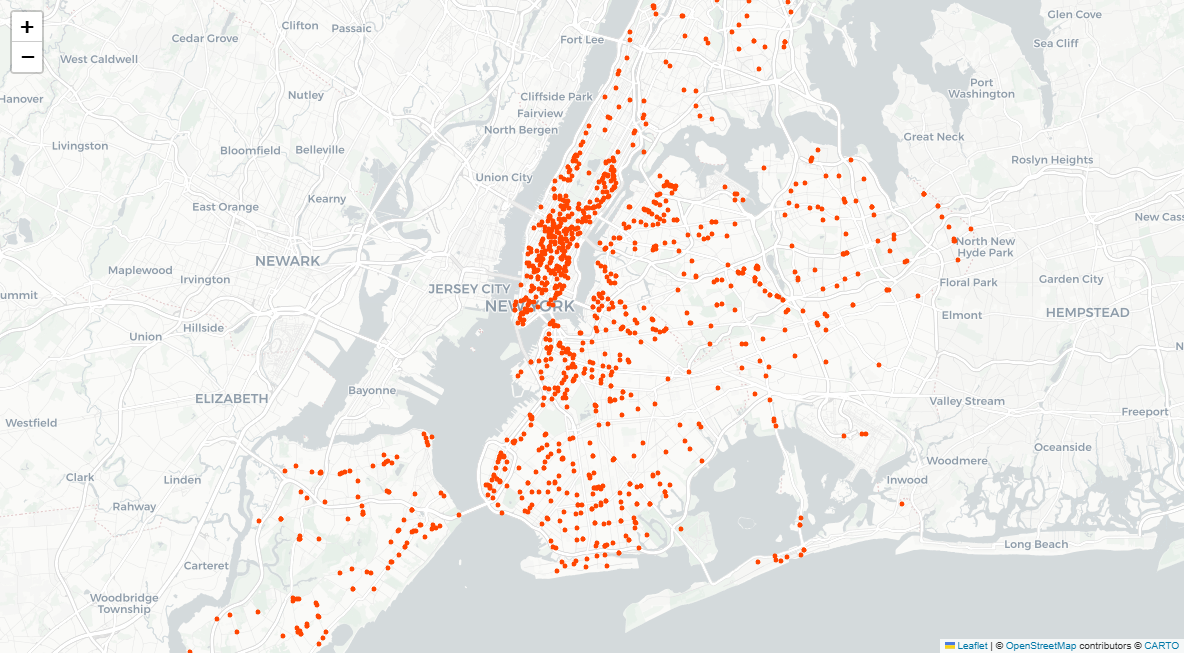

In [6]:
# Final cell to add to your notebook that will output a PNG of your Folium map

# First, save your map to an HTML file
map_html = 'temp_map.html'
m.save(map_html)  # Replace 'my_map' with your actual map variable name

# Use Selenium to convert the map to a PNG image
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import time
import os
from IPython.display import Image

# Configure Chrome in headless mode
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--window-size=1200,800")  # Adjust size as needed
driver = webdriver.Chrome(options=chrome_options)

# Load the HTML file
driver.get(f'file://{os.path.abspath(map_html)}')
time.sleep(2)  # Allow the map to fully render

# Take the screenshot
thumbnail_path = 'map_thumbnail2.png'
driver.save_screenshot(thumbnail_path)
driver.quit()

# Clean up the temporary HTML file
os.remove(map_html)

# Display the image - this will be the cell output that Sphinx can use
Image(filename=thumbnail_path)